## Vectorization

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### 1. Load Data

#### Open-ended Answers

In [2]:
activities = pd.read_csv('./data/activities.csv')

In [3]:
health = pd.read_csv('./data/health.csv')

In [4]:
home_safety = pd.read_csv('./data/home_safety.csv')

## 2. Count vectorization function
#### 2.1. Retrieve bi/trigrams tokens, refine and encode

In [5]:
stopwords = stopwords.words('english')

In [6]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [7]:
def bow_vectorization(data, index, n_grams):
    vectorizer = CountVectorizer(stop_words = stopwords, lowercase = True, strip_accents='unicode', ngram_range=n_grams, preprocessor=removal)
    data_tokens = vectorizer.fit_transform(data)
    print(len(vectorizer.vocabulary_),'words in dictionary.')
    return pd.DataFrame(data_tokens.todense(), columns=vectorizer.get_feature_names(), index=index)

#### 2.2. Search word in vocabulary

In [8]:
def search(word_in=None, word_out=None, vocabulary=None):
    if word_in is None:
        return 'no words to search'

    words = []
    if isinstance(word_in, list):
        for word in word_in:
            for term in vocabulary:
                if word in term:
                    words.append(term)            
    else:
        for term in vocabulary:
            if word_in in term:
                words.append(term)
    
    words_clean = []
    if word_out:
        if isinstance(word_out,str):
            word_out = [word_out]
        print(word_out)
        for word in word_out:
            for term in words:
                if word in term:
                    pass
                else:
                    words_clean.append(term)
        return words_clean
    else:
        return words

## 3. Questions to vectorize

### 3.1. Are you doing other things at home to learn, aside from radio lessons? What are you doing?

Only those who answered "Yes" explained later what they were doing.

In [9]:
# Yes answer
activities[activities.iloc[:,1] == 'Yes'].notnull().sum()

Unnamed: 0                                                                    1499
Q34_Are you doing other things at home to learn, aside from radio lessons?    1499
Q35_What are you doing?                                                       1499
dtype: int64

In [10]:
# No answer
activities[activities.iloc[:,1] == 'No'].notnull().sum()

Unnamed: 0                                                                    1011
Q34_Are you doing other things at home to learn, aside from radio lessons?    1011
Q35_What are you doing?                                                          0
dtype: int64

Counting random words

In [11]:
mask = activities.iloc[:,2].str.contains('read|Read', na=False)
mask.sum()

691

In [12]:
mask_2 = activities.iloc[:,2].str.contains('work|Work', na=False)
mask_2.sum()

109

In [13]:
mask_3 = activities.iloc[:,2].str.contains('Harvest|harvest|culti|Cultiv', na=False)
mask_3.sum()

32

In [14]:
mask_4 = activities.iloc[:,2].str.contains('package', na=False)
mask_4.sum()

60

#### Word vectorization

In [15]:
activities_bi = bow_vectorization(data = activities.iloc[:,2].dropna(), 
                                  index=activities.iloc[:,2].dropna().index, 
                                  n_grams=(1, 1))

456 words in dictionary.


In [16]:
# see 25 most repeated
activities_bi.sum().sort_values(ascending=False)[:25]

reading       595
books         314
notes         132
revising      106
home           96
work           92
read           88
studies        87
studying       76
previous       74
revision       69
cooking        63
study          59
school         55
text           53
textbooks      51
holiday        45
revise         42
group          41
package        37
lessons        36
exercise       32
discussion     32
time           30
book           30
dtype: int64

#### Group words
Group similar words by concepts and count unique apperance

In [17]:
studying = activities_bi[['revise','revised','revising','revision','reading','read', 'book', 'books','note','notes','english',
               'math','maths','mathematics','study','studying','studies', 'science', 'subjects', 'revisions',
              'text', 'textbook','textbooks','homework','practicing','lessons', 'practing', 'lessons','lesson',
              'exercise','exercises','discuss','discussion','discussing','activities']]

In [18]:
housework = activities_bi[['domestic','garden','water','housework','cooking','fetching', 'firewood','collect','cattle',
                           'fetch','household','cleaning','washing','wash','utensils','clothes','clean','chores']]

In [19]:
holiday_package = activities_bi[['holiday','package','packages','holydays']]

In [20]:
external_work = activities_bi[['harvest', 'harvesting','cultivation','caltivation','goat','goats','looking','farm','farming']]

In [21]:
leisure = activities_bi[['play', 'ball','foot','soccer']]

In [22]:
others = activities_bi.drop(studying.columns.tolist() + \
            housework.columns.tolist() + \
            holiday_package.columns.tolist() + \
            external_work.columns.tolist() + \
            leisure.columns.tolist(), axis=1)

Count one per concept apperance (not word)

In [23]:
studying = studying.sum(axis=1)
housework = housework.sum(axis=1)
holiday_package = holiday_package.sum(axis=1)
external_work = external_work.sum(axis=1)
leisure = leisure.sum(axis=1)
others = others.sum(axis=1)

In [24]:
studying[studying != 0] = 1
housework[housework != 0] = 1
holiday_package[holiday_package != 0] = 1
external_work[external_work != 0] = 1
others[others != 0] = 1

In [25]:
study = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['studying'])
study.loc[studying[studying == 1].index,:] = 1
house = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['housework'])
house.loc[housework[housework == 1].index,:] = 1
holiday = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['holiday_package'])
holiday.loc[holiday_package[holiday_package == 1].index,:] = 1
external = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['external_work'])
external.loc[external_work[external_work == 1].index,:] = 1
leisure_time = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['leisure'])
leisure_time.loc[leisure[leisure == 1].index,:] = 1
others_w = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['other'])
others_w.loc[others[others == 1].index,:] = 1

In [26]:
activities_group = pd.concat([study,house,holiday,external,leisure_time,others_w], axis=1)

In [36]:
activities_group.sum()

studying           1250
housework           135
holiday_package      62
external_work        50
leisure              12
other               695
dtype: int64

Visualization

In [38]:
import plotly.graph_objects as go

In [45]:
labels = activities_group.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=activities_group.sum().to_list(),
    text=activities_group.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='Are you doing other things at home to learn, aside from radio lessons?<br><b>What are you doing?</b>')
fig.write_html("data/activities.html")

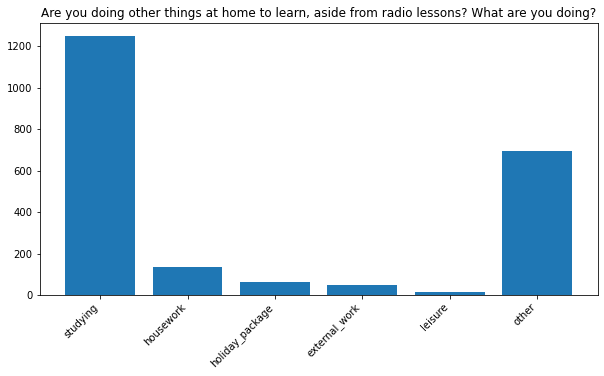

In [35]:
plt.figure(figsize=(10,5))
plt.bar(activities_group.columns.to_list(), activities_group.sum().to_list(), label=activities_group.columns.to_list())
plt.title('Are you doing other things at home to learn, aside from radio lessons? What are you doing?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/activities_group.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Save vectors and concepts

In [71]:
activities_bi.to_csv('data/tokens/activities.csv')
activities_group.to_csv('data/concepts/activities_concepts.csv')

### 3.2. Do you feel worried about your health due to studying/being at home during COVID-19? Why or why not?

In [72]:
health.iloc[:,1].value_counts()

Yes         772
No          528
Somewhat     75
Name: Q46_Do you feel worried about your health due to studying/being at home during COVID-19?, dtype: int64

Get 'Yes' and 'No' answers

In [73]:
# health_yes = health[(health.iloc[:,1] == 'Yes') | (health.iloc[:,1] == 'Somewhat')].iloc[:,2]
health_yes = health[(health.iloc[:,1] == 'Yes')].iloc[:,2]

In [74]:
health_no = health[health.iloc[:,1] == 'No'].iloc[:,2]

#### Bigram vectorization
Worry about studying at home

In [75]:
health_yes_bi = bow_vectorization(data = health_yes.dropna(), 
                                  index= health_yes.dropna().index,
                                  n_grams=(2, 4))

2666 words in dictionary.


In [76]:
health_yes_bi.sum().sort_values(ascending=False)[:60]

corona virus                    33
want live                       22
covid infection                 22
lot things                      14
among people                    13
infection among people          12
infection among                 12
missing lot                     12
missing lot things              12
covid infection among people    11
covid infection among           11
staying home                    10
deadly disease                   9
schools closed                   8
kills people                     7
social distancing                7
fear covid                       7
many people                      6
worried covid                    6
want infected                    6
virus dangerous                  6
dangerous disease                6
study well                       6
disease every                    5
corona virus dangerous           5
kill people                      5
fear corona                      5
covid disease                    5
safe home           

#### Group Bigrams
Bigrams about the disease

In [77]:
affect = search('affect',None, health_yes_bi.columns)
len(affect)

84

In [78]:
# get list of bigrams with "covid"
covid = search(['covid','kill','die'], None, health_yes_bi.columns)
len(covid)

395

In [79]:
# get list of bigrams with "disease"
disease = search('disease', None, health_yes_bi.columns)
len(disease)

246

In [80]:
# get list of bigrams with "pandemic"
pandemic = search('pandemic', None, health_yes_bi.columns)
len(pandemic)

24

In [81]:
# get list of bigrams with "corona"
corona = search('corona', None, health_yes_bi.columns)
len(corona)

165

In [82]:
# get list of bigrams with "infection"
infection = search(['infect','contract'], None, health_yes_bi.columns)
len(infection)

172

In [83]:
# get list of bigrams with "virus"
virus = search('virus', None, health_yes_bi.columns)
len(virus)

151

Bigrams about the waste of time

In [84]:
interrupted = search(['interr','education'], None, health_yes_bi.columns)
len(interrupted)

30

In [85]:
enough = search('enough', 'affect', health_yes_bi.columns)
len(enough)
#health_yes[health_yes.str.contains('enough')].to_list()

['affect']


23

In [86]:
children = search('children', ['covid','coron'], health_yes_bi.columns)
len(children)

['covid', 'coron']


123

In [87]:
# get list of bigrams with "lot"
lot = search('lot', 'coro', health_yes_bi.columns)
len(lot)

['coro']


57

In [88]:
# get list of bigrams with "things"
things = search('thing', None, health_yes_bi.columns)
len(things)

81

In [89]:
# get list of bigrams with "miss"
miss = search('missing', None, health_yes_bi.columns)
len(miss)

21

In [90]:
# get list of bigrams with "time"
time = search('time', None, health_yes_bi.columns)
len(time)

116

In [91]:
# get list of bigrams with "bore"
bore = search('bore', None, health_yes_bi.columns)
len(bore)

5

In [92]:
# get list of bigrams with "idle"
idle = search('idle', None, health_yes_bi.columns)
len(idle)

15

In [93]:
# get list of bigrams with "active"
active = search('active', None, health_yes_bi.columns)
len(active)

15

In [94]:
# get list of bigrams with "closed"
closed = search('closed', None, health_yes_bi.columns)
len(closed)

38

In [95]:
learn = search('learn', ['covid','viru','corona','infect'], health_yes_bi.columns)
len(learn)

['covid', 'viru', 'corona', 'infect']


271

Bigrams about health at home

In [96]:
# get list of bigrams with "home"
home = search('home', None, health_yes_bi.columns)

Count one per concept apperance (not word)

In [97]:
fear_covid = health_yes_bi[list(set(covid+disease+infection+corona+virus+pandemic+affect))]

In [98]:
safe_home = health_yes_bi[home]

In [99]:
miss_school = health_yes_bi[list(set(things+miss+bore+idle+active+learn+closed+lot+enough+children+interrupted))]

The rest of the Bigrams

In [100]:
other = health_yes_bi.drop(fear_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [101]:
#other.columns.to_list()

In [102]:
fear_covid = fear_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
other = other.sum(axis=1)

In [103]:
fear_covid[fear_covid != 0] = 1
safe_home[safe_home != 0] = 1
miss_school[miss_school != 0] = 1
other[other != 0] = 1

In [104]:
fear_c = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear covid'])
fear_c.loc[fear_covid[fear_covid == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['miss school'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['other'])
other_w.loc[other[other == 1].index,:] = 1

In [105]:
health_yes_group = pd.concat([fear_c,safe_h,miss,other_w], axis=1)

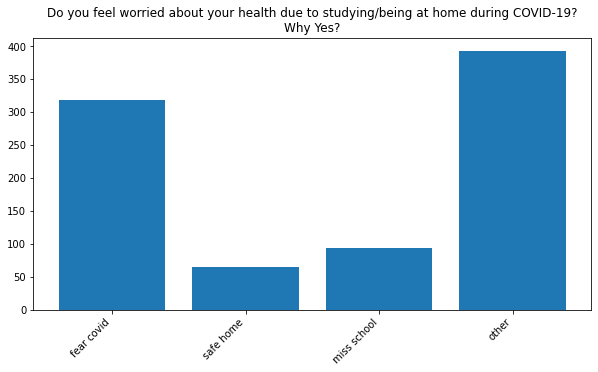

In [106]:
plt.figure(figsize=(10,5))
plt.bar(health_yes_group.columns,health_yes_group.sum())
plt.title('Do you feel worried about your health due to studying/being at home during COVID-19?\nWhy Yes?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/health_yes.jpeg',bbox_inches='tight', dpi=300)
plt.show()

In [107]:
health_yes_group.sum() / health_yes_group.sum(axis=1).sum()

fear covid     0.366667
safe home      0.073563
miss school    0.108046
other          0.451724
dtype: float64

#### Concepts gathering from dataset
Waste of time

In [108]:
things = health_yes.str.contains('thing')

In [109]:
miss = health_yes.str.contains('miss')

In [110]:
time = health_yes.str.contains('time')

In [111]:
active = health_yes.str.contains('active')

In [112]:
idle = health_yes.str.contains('idle')

In [113]:
tire = health_yes.str.contains('tire')

In [114]:
waste = health_yes.str.contains('wast')

In [115]:
learn = (health_yes.str.contains('learn') & ~health_yes.str.contains('covid|Covid'))

Covid

In [116]:
covid_home = (health_yes.str.contains('home')) & (health_yes.str.contains('covid|virus|disease|corona'))
spread_home = (health_yes.str.contains('home')) & (health_yes.str.contains('people|visitor|com|inter|crow'))

In [117]:
idleness = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['idleness'])
idleness.iloc[health_yes[things | time | miss | active | idle | tire | waste].index] = 1
idleness.sum()

idleness    55
dtype: int64

In [118]:
#fear_home = health_yes[covid_home | spread_home]
fear_home = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear home'])
fear_home.iloc[health_yes[covid_home | spread_home].index] = 1
fear_home.sum()

fear home    25
dtype: int64

In [119]:
# fear_outside = health_yes[health_yes.str.contains('Covid|covid|coron|Coron|infection|viru|Vir')]
fear_outside = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear outside'])
fear_outside.iloc[health_yes[health_yes.str.contains('Covid|covid|coron|Coron|infection|viru|Vir')].index] = 1
fear_outside.sum()

fear outside    227
dtype: int64

In [120]:
health_yes_words = pd.concat([idleness, fear_home, fear_outside], axis=1)
health_yes_words.columns = ['idleness','fear home','fear outside']

In [121]:
health_yes_words.sum() / health_yes_group.shape[0]

idleness        0.011635
fear home       0.005289
fear outside    0.048022
dtype: float64

#### Bigram vectorization
Not worry about studying at home

In [122]:
health_no_bi = bow_vectorization(data = health_no.dropna(), 
                                  index= health_no.dropna().index,
                                  n_grams=(2, 4))

1514 words in dictionary.


In [123]:
health_no_bi.sum().sort_values(ascending=False)[:26]

safe home                        56
home safe                        34
stay home                        24
feel safe                        19
staying home                     16
preventive measures              13
feel safe home                   13
home stay                        13
home stay safe                   12
staying home safe                12
stay safe                        12
stay home stay                   11
able protect                     10
stay home stay safe              10
home safety                       9
social distance                   9
preventives measures              9
social distancing                 7
following preventive              7
following preventive measures     6
safe healthy                      6
protect self                      6
protect covid                     5
wash hands                        5
contact people                    5
home safe healthy                 4
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [124]:
# get list of bigrams with "covid"
safe_covid = search('covid', 'home', health_no_bi.columns)
len(safe_covid)

['home']


123

In [125]:
# get list of bigrams with "disease"
safe_disease = search('disease', 'home', health_no_bi.columns)
len(safe_disease)
#health_no[health_no.str.contains('disease')].tolist()

['home']


43

In [126]:
# get list of bigrams with "pandemic"
safe_pandemic = search('pandemic', 'home', health_no_bi.columns)
len(pandemic)
#health_no[health_no.str.contains('pandemic')].tolist()

['home']


24

In [127]:
# get list of bigrams with "corona"
safe_corona = search('corona', 'home', health_no_bi.columns)
len(corona)

['home']


165

In [128]:
# get list of bigrams with "infection"
safe_infection = search('infection', 'home', health_no_bi.columns)
len(infection)

['home']


172

In [129]:
# get list of bigrams with "virus"
safe_virus = search('virus', 'home', health_no_bi.columns)
len(safe_virus)

['home']


18

Bigrams about feeling safe (in/outside Home)

In [130]:
prevention = search(['foll', 'hand', 'measu'], None, health_no_bi.columns)
len(prevention)

234

In [131]:
feel = search('feel', 'worr', health_no_bi.columns)
len(feel)
#health_no[health_no.str.contains('home')].tolist()

['worr']


30

In [132]:
safe_home = search('home', 'safe', health_no_bi.columns)
len(safe_home)

['safe']


225

In [133]:
safe = search('safe', 'home', health_no_bi.columns)
len(safe)

['home']


48

Bigrams about the waste of time

In [134]:
# get list of bigrams with "things"
things = search('thing', None, health_no_bi.columns)
len(things)
#health_no[health_no.str.contains('thing')].tolist()

23

In [135]:
# get list of bigrams with "miss"
miss = search('miss', None, health_no_bi.columns)
len(miss)

13

In [136]:
# get list of bigrams with "time"
time = search('time', None, health_no_bi.columns)
len(time)

15

In [137]:
# get list of bigrams with "lot"
lot = search('lot', None, health_no_bi.columns)
len(lot)

18

In [138]:
go_back = search('back', None, health_no_bi.columns)
len(go_back)

6

Count one per concept apperance (not word)

In [139]:
safe_covid = health_no_bi[list(set(safe_covid+safe_disease+safe_infection+safe_corona+safe_virus+safe_pandemic))]

In [140]:
safe_home = health_no_bi[list(set(safe_home+safe+feel+prevention))]

In [141]:
miss_school = health_no_bi[list(set(things+miss+time+lot+go_back))]

The rest of the Bigrams

In [142]:
other = health_no_bi.drop(safe_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)
test_other = health_no_bi.drop(safe_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [143]:
safe_covid = safe_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
other = other.sum(axis=1)

In [144]:
safe_covid[safe_covid != 0] = 1
safe_home[safe_home != 0] = 1
miss_school[miss_school != 0] = 1
other[other != 0] = 1

In [145]:
safe_c = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe_covid'])
safe_c.loc[safe_covid[safe_covid == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe_home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['miss_school'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['other_w'])
other_w.loc[other[other == 1].index,:] = 1

In [146]:
health_no_group = pd.concat([safe_c,safe_h,miss,other_w], axis=1)

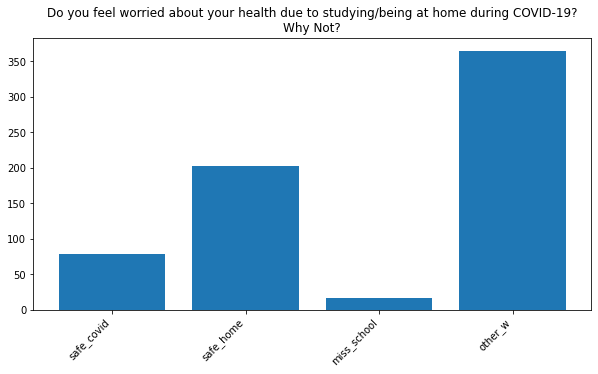

In [207]:
plt.figure(figsize=(10,5))
plt.bar(health_no_group.columns, health_no_group.sum())
plt.title('Do you feel worried about your health due to studying/being at home during COVID-19?\nWhy Not?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/health_no.jpeg',bbox_inches='tight', dpi=300)
plt.show()

In [148]:
health_no_group.sum() / health_no_group.sum(axis=1).sum()

safe_covid     0.119155
safe_home      0.306184
miss_school    0.024133
other_w        0.550528
dtype: float64

#### Concepts gathering from Dataset
Feeling safe

In [149]:
health_yes_group = pd.concat([fear_c,safe_h,miss,other_w], axis=1)

In [150]:
safe_covid = health_no.str.contains('covid')
safe_covid.sum()

21

In [151]:
safe_home = health_no.str.contains('home')
safe_home.sum()

190

In [152]:
safe = health_no.str.contains('safe') & ~health_no.str.contains('home')
safe.sum()

43

Waste time

In [153]:
nothing = health_no.str.contains('thing')
nothing.sum()

8

In [154]:
waste = health_no.str.contains('lot')
waste.sum()

4

In [155]:
go_back = (health_no.str.contains('school')) & (health_no.str.contains('go'))
go_back.sum()

2

#### Save vectors and concepts

In [156]:
# tokens
health_yes_bi.to_csv('data/tokens/health_home_yes.csv')
health_no_bi.to_csv('data/tokens/health_home_no.csv')
# concepts
health_yes_group.to_csv('data/concepts/health_yes_concepts.csv')
health_no_group.to_csv('data/concepts/health_no_concepts.csv')

### 3.3. Do you feel worried about your safety due to being at home during COVID-19? Why or why not?

In [157]:
home_safety.iloc[:,1].value_counts()

Yes         666
No          648
Somewhat     61
Name: Q48_Do you feel worried about your safety due to being at home during COVID-19?, dtype: int64

Group 'Yes' and 'Somewhat' answers and separate them from the negative answers

In [158]:
home_safety_yes = home_safety[(home_safety.iloc[:,1] == 'Yes') | (home_safety.iloc[:,1] == 'Somewhat')].iloc[:,2]

In [159]:
home_safety_no = home_safety[home_safety.iloc[:,1] == 'No'].iloc[:,2]

#### Bigram vectorization
Worry about safety at home

In [160]:
home_safety_yes_bi = bow_vectorization(data = home_safety_yes.dropna(),
                                       index =  home_safety_yes.dropna().index,
                                       n_grams=(2, 3))

1936 words in dictionary.


In [161]:
home_safety_yes_bi.sum().sort_values(ascending=False)[:20]

corona virus           43
staying home           15
fear corona            14
disease affect         13
come home              12
fear corona virus      11
safe home              11
movements people       11
pandemic everywhere    11
fear disease           11
social distancing      10
affect everywhere      10
people home             9
want infected           9
feel safe               8
home safe               8
staying home safe       7
many people             7
feel safe home          7
dangerous disease       7
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [162]:
# get list of bigrams with "covid"
covid = search('covid', 'home', home_safety_yes_bi.columns)
len(covid)

['home']


128

In [163]:
# get list of bigrams with "disease"
disease = search('disease', 'home', home_safety_yes_bi.columns)
len(disease)
#health_no[health_no.str.contains('disease')].tolist()

['home']


117

In [164]:
# get list of bigrams with "pandemic"
pandemic = search('pandemic', 'home', home_safety_yes_bi.columns)
len(pandemic)
#health_no[health_no.str.contains('pandemic')].tolist()

['home']


33

In [165]:
# get list of bigrams with "corona"
corona = search('corona', None, home_safety_yes_bi.columns)
len(corona)

98

In [166]:
# get list of bigrams with "infection"
infection = search('infect', None, home_safety_yes_bi.columns)
len(infection)

78

In [167]:
# get list of bigrams with "virus"
virus = search('virus', None, home_safety_yes_bi.columns)
len(virus)

117

In [168]:
# get list of bigrams with "fear"
fear = search(['fear','death','kill'], 'home', home_safety_yes_bi.columns)
len(fear)

['home']


87

Bigrams about home and safety

In [169]:
worry_home = search('home', 'safe', home_safety_yes_bi.columns)
len(worry_home)

['safe']


190

In [170]:
safe_out = search('safe', ['home','fear','safe'], home_safety_yes_bi.columns)
len(safe_out)

['home', 'fear', 'safe']


115

In [171]:
safe_home = search(['home', 'safe'], None, home_safety_yes_bi.columns)
len(safe_home)

265

Bigrams about school

In [172]:
school = search('school', 'virus', home_safety_yes_bi.columns)
len(school)

['virus']


73

In [173]:
lots = search('lot', 'virus', home_safety_yes_bi.columns)
len(lots)

['virus']


40

In [174]:
miss = search('miss', 'virus', home_safety_yes_bi.columns)
len(miss)

['virus']


21

In [175]:
things = search('things', 'virus', home_safety_yes_bi.columns)
len(things)

['virus']


28

In [176]:
waste = search('waste', 'virus', home_safety_yes_bi.columns)
len(waste)

['virus']


12

In [177]:
lose = search(['lost','losing'], 'virus', home_safety_yes_bi.columns)
len(lose)

['virus']


16

In [178]:
time = search('time', ['virus','infect','diseas','worr','pandem'], home_safety_yes_bi.columns)
len(time)

['virus', 'infect', 'diseas', 'worr', 'pandem']


255

Count one per concept apperance (not word)

In [179]:
worry_covid = home_safety_yes_bi[list(set(covid+disease+infection+corona+virus+pandemic))]

In [180]:
safe_home = home_safety_yes_bi[list(set(safe_home))]

In [181]:
miss_school = home_safety_yes_bi[list(set(things+miss+lots+waste+lose+time))]

In [182]:
worry_home = home_safety_yes_bi[list(set(worry_home))]

The rest of the Bigrams

In [183]:
other = home_safety_yes_bi.drop(safe_home.columns.to_list() + worry_covid.columns.to_list() + worry_home.columns.to_list() + miss_school.columns.to_list(), axis=1)
test_other = home_safety_yes_bi.drop(safe_home.columns.to_list() + worry_covid.columns.to_list() + worry_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [184]:
worry_covid = worry_covid.sum(axis=1)
worry_home = worry_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
safe_home = safe_home.sum(axis=1)
other = other.sum(axis=1)

In [185]:
worry_covid[worry_covid != 0] = 1
worry_home[worry_home != 0] = 1
miss_school[miss_school != 0] = 1
safe_home[safe_home != 0] = 1
other[other != 0] = 1

In [186]:
worry_c = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['worry covid'])
worry_c.loc[worry_covid[worry_covid == 1].index,:] = 1
worry_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['worry home'])
worry_h.loc[worry_home[worry_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['waste time'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['safe home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['other topics'])
other_w.loc[other[other == 1].index,:] = 1

In [187]:
home_safety_yes_group = pd.concat([worry_c,worry_h,miss,safe_h,other_w], axis=1)

Visualization

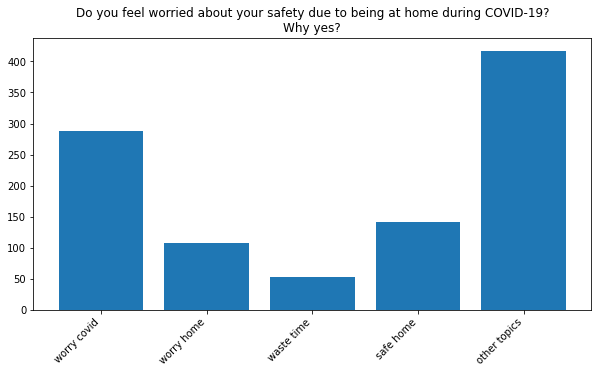

In [188]:
plt.figure(figsize=(10,5))
plt.bar(home_safety_yes_group.columns,home_safety_yes_group.sum())
plt.title('Do you feel worried about your safety due to being at home during COVID-19?\nWhy yes?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/home_safety_yes.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Bigram vectorization
Not Worried about safecty at home

In [189]:
home_safety_no_bi = bow_vectorization(data = home_safety_no.dropna(),
                                      index = home_safety_no.dropna().index,
                                      n_grams=(2, 3))

1252 words in dictionary.


In [190]:
home_safety_no_bi.sum().sort_values(ascending=False)[:25]

safe home                74
home safe                49
feel safe                34
social distancing        30
stay home                30
feel safe home           26
staying home             22
preventive measures      18
stay safe                17
safety measures          16
home stay                15
stay home stay           15
home stay safe           15
staying home safe        14
social distance          12
wash hands               10
home safety               9
safe healthy              9
home safe healthy         8
safety measures covid     7
washing hands             7
measures covid            7
take care                 6
come contact              5
following preventive      5
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [191]:
no_fear_virus = search(['covid','disease','pandemic','corona','vir','infect','contra','fear','kill','dea'], 'home', home_safety_no_bi.columns)
len(no_fear_virus)

['home']


173

Bigrams about home and safety

In [192]:
no_fear_virus_home = search(['home', 'safe'], None, home_safety_no_bi.columns)
len(safe_home)

727

Bigrams about prevention

In [193]:
hands = search('hands', None, home_safety_no_bi.columns)
len(hands)

62

In [194]:
distance = search(['distance','social'], None, home_safety_no_bi.columns)
len(distance)
#home_safety_no[home_safety_no.str.contains('school')].to_list()

101

In [195]:
measures = search(['measures','prevent','precau','care','prot'], None, home_safety_no_bi.columns)
len(measures)

190

In [196]:
stay = search('stay', None, home_safety_no_bi.columns)
len(stay)

81

Count one per concept apperance (not word)

In [197]:
no_fear_covid = home_safety_no_bi[no_fear_virus]

In [198]:
safe_home = home_safety_no_bi[no_fear_virus_home]

In [199]:
prevention = home_safety_no_bi[list(set(hands + distance + stay))]

The rest of the Bigrams

In [200]:
other = home_safety_no_bi.drop(no_fear_covid.columns.to_list() + safe_home.columns.to_list() + prevention.columns.to_list(), axis=1)
test_other = home_safety_no_bi.drop(no_fear_covid.columns.to_list() + safe_home.columns.to_list() + prevention.columns.to_list(), axis=1)

In [201]:
no_fear_covid = no_fear_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
prevention = prevention.sum(axis=1)
other = other.sum(axis=1)

In [202]:
no_fear_covid[no_fear_covid != 0] = 1
safe_home[safe_home != 0] = 1
prevention[prevention != 0] = 1
other[other != 0] = 1

In [203]:
n_f_c = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['no fear virus'])
n_f_c.loc[no_fear_covid[no_fear_covid == 1].index,:] = 1
prev = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['preventive measures'])
prev.loc[prevention[prevention == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['safe at home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [204]:
home_safety_no_group = pd.concat([n_f_c, prev, safe_h, other_w], axis=1)

Visualization

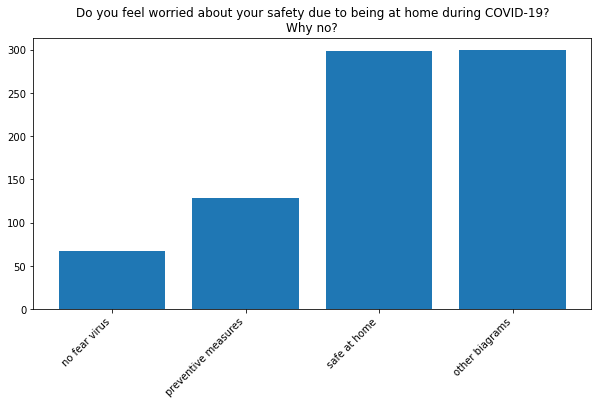

In [205]:
plt.figure(figsize=(10,5))
plt.bar(home_safety_no_group.columns, home_safety_no_group.sum())
plt.title('Do you feel worried about your safety due to being at home during COVID-19?\nWhy no?')
plt.savefig('data/imgs/home_safety_no.jpeg',bbox_inches='tight', dpi=300)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Save vectors and concepts

In [206]:
# tokens
home_safety_yes_bi.to_csv('data/tokens/safety_home_yes.csv')
home_safety_no_bi.to_csv('data/tokens/health_home_no.csv')
# concepts
home_safety_yes_group.to_csv('data/concepts/safety_home_yes_concepts.csv')
home_safety_no_group.to_csv('data/concepts/health_home_no_concepts.csv')